# Image classification machine learning algorithm
## Platinum cyclic voltammetry scan facet detection through image classification

Developed by: Heather Baroody and Tasleem Muzaffar
17 May 2018

This is a general image classification model that is trained to distingush between four distinct Platinum cyclic voltammetry scans for different surface facets: Pt(111), Pt(110), Pt(100), and polycrystalline Pt.  This was developed during this 2018 ECS Data Hack Week in Seattle so the goal is to develop a simple model in the short amount of time we have and expand it later. 

In [245]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
from sklearn.decomposition import PCA
from PIL import Image

### Pre - Image proccessing and standardizing data

The inital data sets were created by extracting Pt(jkl) CV data point from a variety of literature studies as a principal of proof. The images are standardized by converting the .jpg to grayscale and resizing. In the future the goal is to use actual images of CV scans in literature with the hope of having >50 images per Pt facet.

In [186]:
img = Image.open("pt111-1.jpg").convert('I')
arr = np.array(img)
arr.shape
imgrs = img.resize((100, 100))
arrrs = np.array(imgrs)
print (arrrs)
imgrs.show()

[[255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 ..., 
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]]


## Building the Model
### Processing the entire training/test set
Loop through and process all images in for training/test set and convert to a matrix with number of rows = number of samples.

In [246]:
files = []
num111 = 12
num110 = 7
num100 = 8
numpoly = 10
l1 = ['111','110','100','poly']
l2=[num111, num110, num100, numpoly]
for j in range(len(l1)):
    for i in range(l2[j]):
        files.append("xpt{}-{}.jpg".format(l1[j],i+1))

images = []
for file in files:
    images.append(Image.open(file).convert('I'))

#resize image files
x_pix = 120
y_pix = 120
image_rs = []

for i in images:
    image_rs.append(i.resize((x_pix, y_pix)))

#convert to array
image_ar = []
for j in image_rs:
    image_ar.append(np.array(j))

image_ar = np.array(image_ar)
print(image_ar.shape)

(37, 120, 120)


In [247]:
# resize matrix for use in algorithm
dim = np.dot(image_ar.shape[1],image_ar.shape[2])
data = np.reshape(image_ar, (image_ar.shape[0], dim))
data.shape

(37, 14400)

### Define target values
Create the vector of target values that correlate to the data and corresponding target names.

In [248]:
#Define target values
Pt111_index = np.zeros((1,num111))
Pt110_index = np.ones((1,num110))
Pt100_index = 2*np.ones((1,num100))
Ptpoly_index = 3*np.ones((1,numpoly))

target = np.concatenate((Pt111_index,Pt110_index,Pt100_index,Ptpoly_index),axis=1)
target = target.reshape(data.shape[0],)
print(target)

#target = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,3,3])

facet = ['Pt (111)', 'Pt(110)', 'Pt(100)', 'Pt(poly)']
print(target.shape)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.
  1.  2.  2.  2.  2.  2.  2.  2.  2.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.]
(37,)


Split data into training set and test set

In [249]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(data, target,
                                                random_state=2)
print(Xtrain.shape, Xtest.shape)

#print(Xtrain[Xtrain != 255][0:10])

((27, 14400), (10, 14400))


## Applying and comparing various learning alogorithms
### 1 - Logistic regression

In [250]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l2')
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)

Check accuracy score

In [251]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, ypred)

1.0

Validate model

In [252]:
test = np.array([data[2]])
test.shape
usertest = clf.predict(test)
usertest = np.int(usertest)
print (facet[usertest])

Pt (111)


### 2 - K nearest neighbors classifier

In [214]:
from sklearn import neighbors

# create the model
knn = neighbors.KNeighborsClassifier(n_neighbors=5)

# fit the model
knn.fit(data, target)


test = np.array([data[13]])
test.shape
usertest = clf.predict(test)

result = knn.predict(test)

print(facet[np.int(result)])

knn.predict_proba(test)

Pt(110)


array([[ 0.,  1.,  0.,  0.]])

Check accuracy score

In [215]:
knn.score(data, target, sample_weight=None)

0.48648648648648651

### 3 - unsupervised Isomap

In [216]:
from sklearn.manifold import Isomap
iso = Isomap(n_components=2)
data_projected = iso.fit_transform(data)
data_projected.shape

(37, 2)

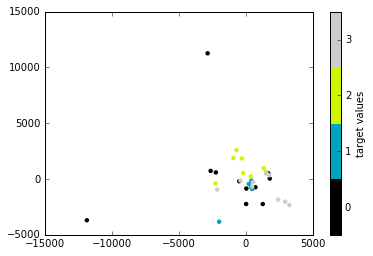

In [217]:
plt.scatter(data_projected[:, 0], data_projected[:, 1], c=target,
            edgecolor='none', alpha=1, cmap=plt.cm.get_cmap('nipy_spectral', 4));
plt.colorbar(label='target values', ticks=range(4))
plt.clim(-0.5, 3.5)

## Model Accuracy visulaization

In [262]:
print(Xtest.shape)
print(len(Xtest))
Xtest_rs = []

for i in Xtest:
    Xtest_rs.append(i.reshape(x_pix,y_pix))

test_img = []
for j in Xtest_rs:
    test_img.append(Image.fromarray(j, 'I'))

#test_img[2].show()

##
#x_tpix = 100
#y_tpix = 100
#
#test_img_rs= test_img[1].resize((x_tpix, y_tpix))
#test_img_rs.show()

x_tpix = 100
y_tpix = 100
test_img_rs = []
for k in test_img:
    test_img_rs.append(k.resize((x_tpix, y_tpix)))

print(test_img_rs)
#img = Image.fromarray(Xtest_rs[0], 'I')
#img.save('my.png')
test_img_rs[4].show()
#Xtestresize = Xtest.resize((100, 100))

fig, axes = plt.subplots(5,2, figsize=(x_tpix, y_tpix))
fig.subplots_adjust(hspace=0.1, wspace=0.1)


for l, ax in enumerate(axes.flat):
    ax.imshow(test_img_rs[l], cmap='binary')
    ax.text(10, 10, str(ypred[l]),
            transform=ax.transAxes,
            color='green' if (ytest[l] == ypred[l]) else 'red')
    ax.set_xticks([])
    ax.set_yticks([])

(10, 14400)
10
[<PIL.Image.Image image mode=I size=100x100 at 0x1A189B13B0>, <PIL.Image.Image image mode=I size=100x100 at 0x1A0EF4E1B8>, <PIL.Image.Image image mode=I size=100x100 at 0x1A0EF540E0>, <PIL.Image.Image image mode=I size=100x100 at 0x1A0EF541B8>, <PIL.Image.Image image mode=I size=100x100 at 0x1A0EF54128>, <PIL.Image.Image image mode=I size=100x100 at 0x1A0EF39518>, <PIL.Image.Image image mode=I size=100x100 at 0x1A1DF62CF8>, <PIL.Image.Image image mode=I size=100x100 at 0x1A18A5B638>, <PIL.Image.Image image mode=I size=100x100 at 0x1A18A5B710>, <PIL.Image.Image image mode=I size=100x100 at 0x1A18A5B9E0>]
